# Accident Analysis in Barcelona
In this notebook, I’ll be working with accident data from the Urban Guard in Barcelona. I’ll clean the data, explore patterns through EDA, and build a modeling pipeline to understand what factors contribute to accidents.This will help uncover insights that could help improve road safety in the city


### Imports

In [1]:
import os
import time
from collections import Counter
from pathlib import Path
from PIL import Image

import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split,
    cross_val_score,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.class_weight import compute_class_weight

import geopandas as gpd

import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier

import optuna

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

from dotenv import load_dotenv

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from numpy.random import RandomState

from IPython.display import display

c:\Users\HP\Desktop\Projects\Hackaton_barcelona_activa\Barcelona_accident_analysis\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
csv_dir = "./data/2023_accidents_causa_conductor_gu_bcn_.csv"
data = pd.read_csv(csv_dir)
data.head(5)

,Numero_expedient,Codi_districte,Nom_districte,Codi_barri,Nom_barri,Codi_carrer,Nom_carrer,Num_postal,Descripcio_dia_setmana,NK_Any,Mes_any,Nom_mes,Dia_mes,Hora_dia,Descripcio_torn,Descripcio_causa_mediata,Coordenada_UTM_X_ED50,Coordenada_UTM_Y_ED50,Longitud_WGS84,Latitud_WGS84
0,2023S000699,-1,Desconegut,-1,Desconegut,-1,Rovira (ascendent) ...,0,Dissabte,2023,2,Febrer,4,16,Tarda,Manca d'atenció a la conducció,430443.36,4585232.00,2.166596,41.413783
1,2023S005197,-1,Desconegut,-1,Desconegut,-1,Estatut de Catalunya ...,11,Divendres,2023,9,Setembre,1,13,Matí,No respectar distàncies,429493.73,4587108.15,2.155015,41.430598
2,2023S007430,-1,Desconegut,-1,Desconegut,-1,Rovira (ascendent) ...,0,Divendres,2023,12,Desembre,15,11,Matí,No respectar distàncies,430443.36,4585232.00,2.166596,41.413783
3,2023S000961,-1,Desconegut,-1,Desconegut,-1,Amílcar ...,120,Dissabte,2023,1,Gener,28,14,Tarda,No respectat pas de vianants,430955.45,4586335.10,2.172596,41.423762
4,2023S006486,-1,Desconegut,-1,Desconegut,-1,Augusta / Hort de la Vila ...,NaN,Dijous,2023,11,Novembre,2,14,Tarda,Desobeir semàfor,426883.33,4583690.92,2.124189,41.399587


## EDA

### Data cleaning

In [3]:
data.columns

Index(['Numero_expedient', 'Codi_districte', 'Nom_districte', 'Codi_barri',
       'Nom_barri', 'Codi_carrer', 'Nom_carrer', 'Num_postal ',
       'Descripcio_dia_setmana', 'NK_Any', 'Mes_any', 'Nom_mes', 'Dia_mes',
       'Hora_dia', 'Descripcio_torn', 'Descripcio_causa_mediata',
       'Coordenada_UTM_X_ED50', 'Coordenada_UTM_Y_ED50', 'Longitud_WGS84',
       'Latitud_WGS84'],
      dtype='object')

#### Typos

Num_postal has an error in the colum name

In [4]:
data.columns=data.columns.str.strip() #Num_postal with typo in the column name

This will clean any typos in the categorical columns

In [5]:
def get_categorical_columns(df):
    return df.select_dtypes(include=['object']).columns.tolist()
cat_cols=get_categorical_columns(data)

for col in cat_cols:
    if data[col].isnull().any():
        data[col] = data[col].fillna('')
    data[col] = data[col].str.strip()
    data[col] = data[col].str.replace(' ', '_')
    
print(f"Cleaned categorical columns:\n{'\n'.join(cat_cols)}")

Cleaned categorical columns:
Numero_expedient
Nom_districte
Nom_barri
Nom_carrer
Num_postal
Descripcio_dia_setmana
Nom_mes
Descripcio_torn
Descripcio_causa_mediata


In [6]:
# nom_districte has 104 rows that are 'desconegut'(unknown), I will drop them

data=data[data['Nom_districte']!='desconegut']

count_desconegut = (data['Nom_districte'] == 'desconegut').sum()
print(count_desconegut)

0


In [7]:
for col in data.columns:
    print(f'{col}: {data[col].nunique()}')

Numero_expedient: 7721
Codi_districte: 11
Nom_districte: 11
Codi_barri: 74
Nom_barri: 74
Codi_carrer: 1074
Nom_carrer: 1046
Num_postal: 1918
Descripcio_dia_setmana: 7
NK_Any: 1
Mes_any: 12
Nom_mes: 12
Dia_mes: 31
Hora_dia: 24
Descripcio_torn: 3
Descripcio_causa_mediata: 16
Coordenada_UTM_X_ED50: 4808
Coordenada_UTM_Y_ED50: 4804
Longitud_WGS84: 4821
Latitud_WGS84: 4822


codi_carrer cleaning    

In [8]:
#codi_carrer unique values: 1040. nom_carrer: unique values: 1073
data.drop('Codi_carrer', axis=1, inplace=True)


#### Duplicates

In [9]:
print(f'Duplicated rows:{data.duplicated().sum()}')
print (f'first row duplicates: {data['Numero_expedient'].duplicated().sum()}')

Duplicated rows:0
first row duplicates: 1176


In [10]:
# Some accidents have the same 'Numero_expedient' but different 'Descripcio_causa_mediata',
# so I'm keeping the first one and dropping the rest

duplicates = data.duplicated(subset=['Numero_expedient'], keep=False)

# Filtering rows that are not duplicates or that do not have 'Altres' in 'Descripcio_causa_mediata'

data = data.loc[~((data['Descripcio_causa_mediata'] == 'altres') & duplicates)]


# Data Visualization

C:\Users\HP\AppData\Local\Temp\ipykernel_27276\511603217.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["Dia_mes"])['Numero_expedient'].count().plot(kind="bar", ax=axes[2, 1])


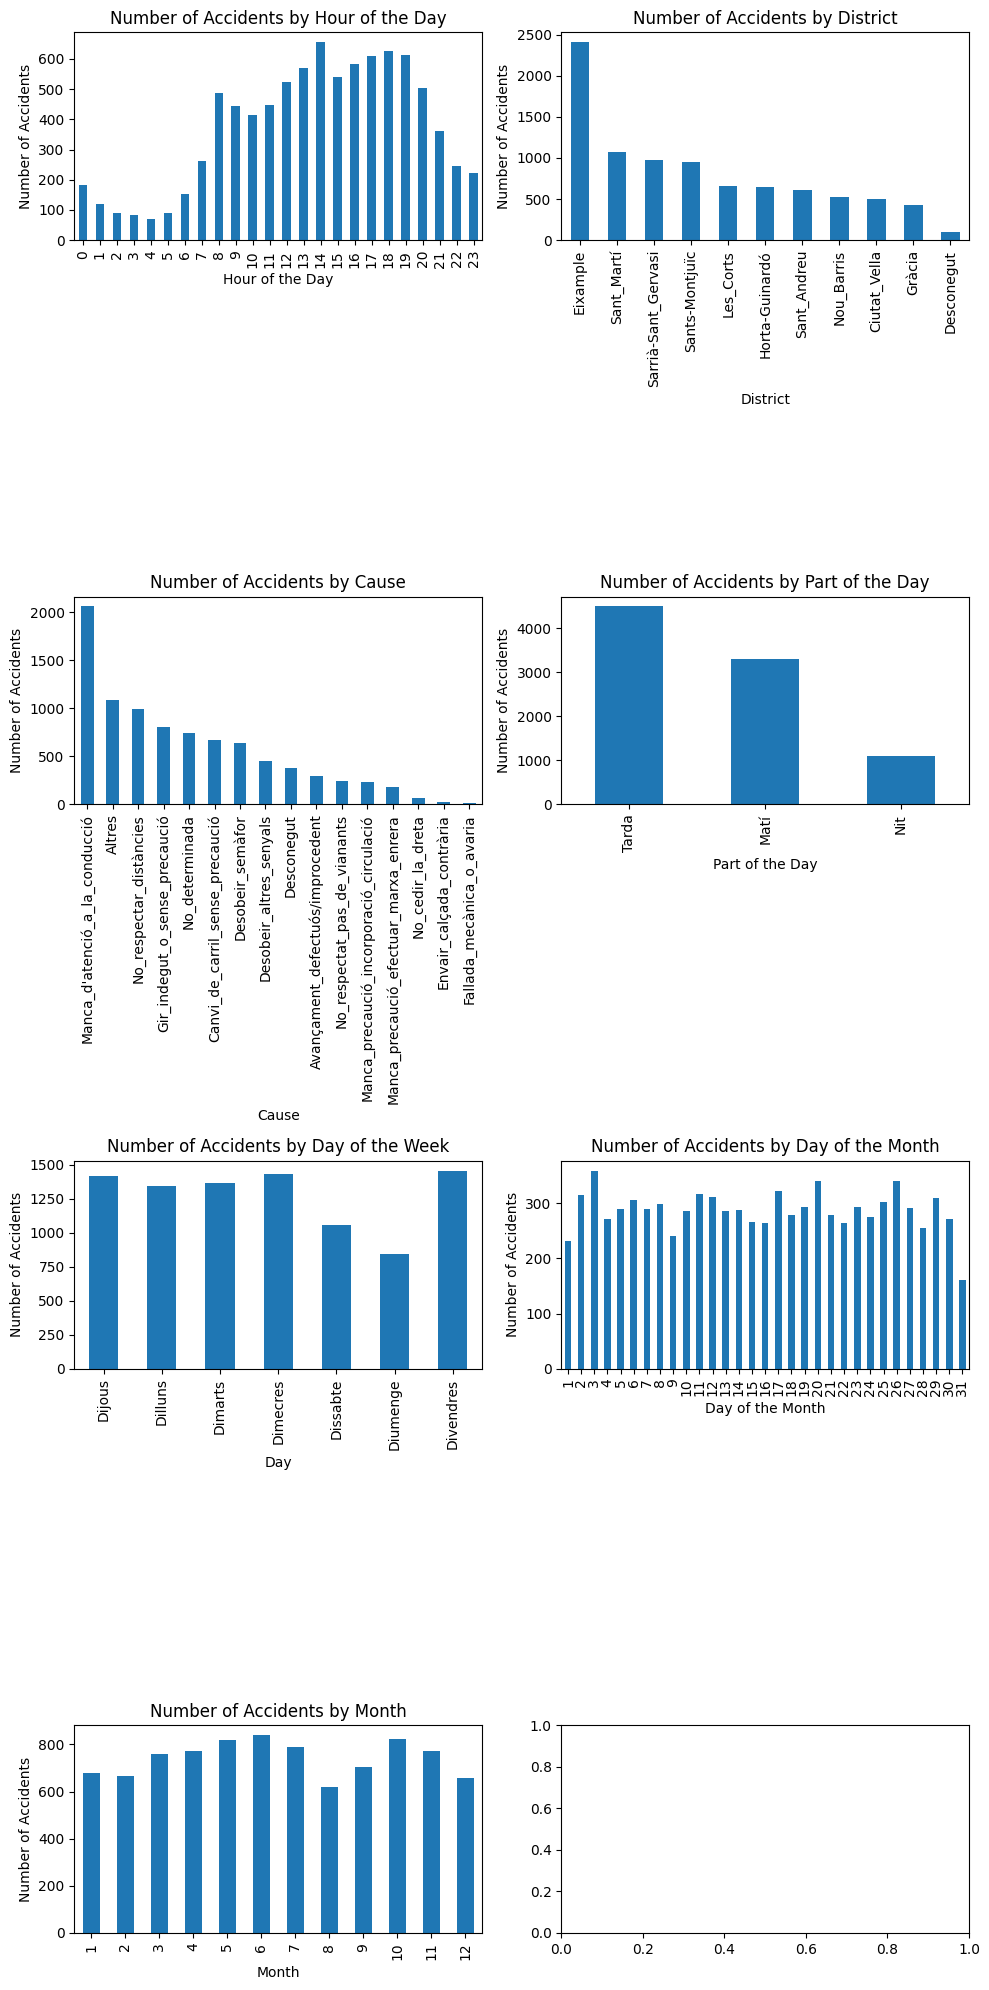

In [14]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))  # Adjusted nrows and ncols

# Plot 1: Histogram of accidents by hour of the day
data.groupby(["Hora_dia"])['Numero_expedient'].count().plot(kind="bar", ax=axes[0, 0])
axes[0, 0].set_title('Number of Accidents by Hour of the Day')
axes[0, 0].set_xlabel('Hour of the Day')
axes[0, 0].set_ylabel('Number of Accidents')

# Plot 2: Number of accidents by district
data.groupby(["Nom_districte"])['Numero_expedient'].count().sort_values(ascending=False).plot(kind="bar", ax=axes[0, 1])
axes[0, 1].set_title('Number of Accidents by District')
axes[0, 1].set_xlabel('District')  # Changed 'Day' to 'District'
axes[0, 1].set_ylabel('Number of Accidents')

# Plot 3: Number of accidents by cause
data.groupby(["Descripcio_causa_mediata"])['Numero_expedient'].count().sort_values(ascending=False).plot(kind="bar", ax=axes[1, 0])
axes[1, 0].set_title('Number of Accidents by Cause')
axes[1, 0].set_xlabel('Cause')
axes[1, 0].set_ylabel('Number of Accidents')

# Plot 4: Number of accidents by parte of the day
data.groupby(["Descripcio_torn"])['Numero_expedient'].count().sort_values(ascending=False).plot(kind="bar", ax=axes[1, 1])
axes[1, 1].set_title('Number of Accidents by Part of the Day')
axes[1, 1].set_xlabel('Part of the Day')
axes[1, 1].set_ylabel('Number of Accidents')

# Plot 5: Number of accidents by day of the week (Chronological Order)
data.groupby(["Descripcio_dia_setmana"])['Numero_expedient'].count().plot(kind="bar", ax=axes[2, 0])
axes[2, 0].set_title('Number of Accidents by Day of the Week')
axes[2, 0].set_xlabel('Day')
axes[2, 0].set_ylabel('Number of Accidents')

# Plot 6: Number of accidents by day of the month (Chronological Order)
day_month_order = range(1, 32)  # Days in a month
data['Dia_mes'] = pd.Categorical(data['Dia_mes'], categories=day_month_order, ordered=True)
data.groupby(["Dia_mes"])['Numero_expedient'].count().plot(kind="bar", ax=axes[2, 1])
axes[2, 1].set_title('Number of Accidents by Day of the Month')
axes[2, 1].set_xlabel('Day of the Month')
axes[2, 1].set_ylabel('Number of Accidents')

# Plot 7: Number of accidents by month (Chronological Order)
data.groupby(["Mes_any"])['Numero_expedient'].count().plot(kind="bar", ax=axes[3, 0])
axes[3, 0].set_title('Number of Accidents by Month')
axes[3, 0].set_xlabel('Month')
axes[3, 0].set_ylabel('Number of Accidents')

# Adjust spacing between subplots
plt.tight_layout()

# Display all plots together
plt.show()

In [16]:
data['Descripcio_causa_mediata'].value_counts()


Descripcio_causa_mediata
Manca_d'atenció_a_la_conducció             2061
Altres                                     1089
No_respectar_distàncies                     996
Gir_indegut_o_sense_precaució               804
No_determinada                              743
Canvi_de_carril_sense_precaució             666
Desobeir_semàfor                            640
Desobeir_altres_senyals                     457
Desconegut                                  377
Avançament_defectuós/improcedent            296
No_respectat_pas_de_vianants                241
Manca_precaució_incorporació_circulació     238
Manca_precaució_efectuar_marxa_enrera       177
No_cedir_la_dreta                            72
Envair_calçada_contrària                     25
Fallada_mecànica_o_avaria                    15
Name: count, dtype: int64

## Map View

In [12]:
# Filter out invalid or missing latitude/longitude values
data = data.dropna(subset=['Latitud_WGS84', 'Longitud_WGS84'])
data = data[(data['Latitud_WGS84'].notnull()) & (data['Longitud_WGS84'].notnull())]

# Convert to list of lists
heat_data = [[float(row['Latitud_WGS84']), float(row['Longitud_WGS84'])] for index, row in data.iterrows()]

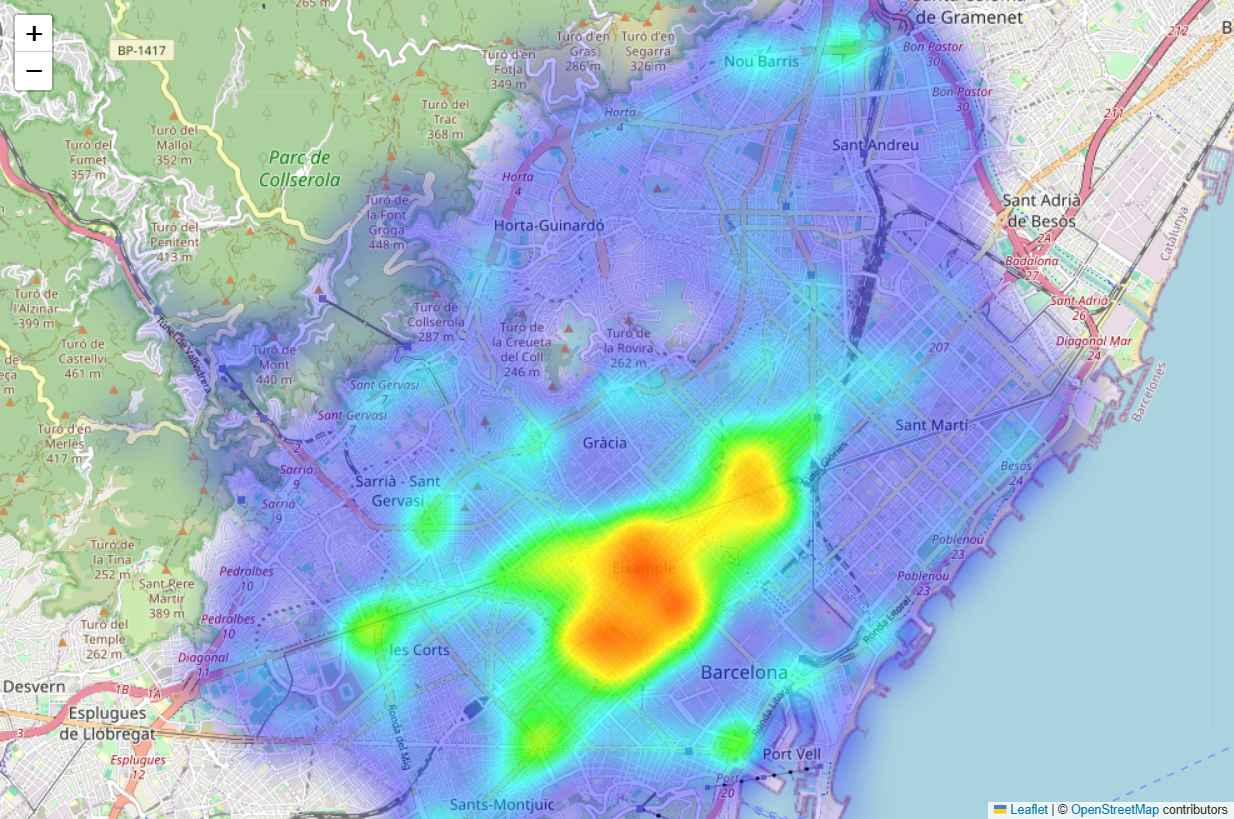

In [13]:
# Create a folium map 
barcelona_map = folium.Map(location=[41.41, 2.16], zoom_start=12.5)

# Add the heatmap layer
HeatMap(heat_data, blur=30, min_opacity=0.2).add_to(barcelona_map)
barcelona_map.save("barcelona_heatmap.html")

def render_folium_map(map_object, html_path, png_path, width=1000, height=800, wait_time=5):
    """
    Render a Folium map as a static image and save both HTML and PNG versions.
    
    Parameters:
    - map_object: A Folium map object
    - html_path: Path to save the HTML version of the map
    - png_path: Path to save the PNG version of the map
    - width: Width of the browser window (default 1000)
    - height: Height of the browser window (default 800)
    - wait_time: Time to wait for the map to render in seconds (default 5)
    
    Returns:
    - Displays the PNG image in the notebook
    """
    # change routes to path for compability
    html_path = Path(html_path).resolve()
    png_path = Path(png_path).resolve()
    
    # Save the map to the specified HTML file
    map_object.save(html_path)
    
    # Set up the web driver
    options = Options()
    options.add_argument('--headless')  # Run in background
    options.add_argument('--disable-gpu')  # Disable GPU for headless mode
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)
    
    try:
        # Open the HTML file
        driver.get(f"file://{html_path}")
        
        # Wait for the map to render
        time.sleep(wait_time)
        
        # Set the size of the browser window
        driver.set_window_size(width, height)
        
        # Capture the screenshot
        driver.save_screenshot(png_path)
        
        # Display the image in the notebook
        
        display(Image.open(png_path))

    finally:
        # Close the browser
        driver.quit()

# Call the function
render_folium_map(barcelona_map, "data/barcelona_heatmap.html", "data/barcelona_heatmap.png")
       

---
# Insight Analysis

We can see that **Eixample** is the district with the most accidents, and within it, the neighborhood **La Dreta de Eixample** leads the chart.

Additionally, there is a noticeable trend of an increase in the number of accidents during specific hours, mainly between **2:00 PM and 8:00 PM**.

Regarding the cause, **lack of attention while driving** is the leading cause of accidents.

There doesn’t seem to be a significant difference in the number of accidents by day of the week, except for a decrease on **Saturdays and Sundays**.




### Explanation for Choosing a Classification

I decided to approach this problem as a classification task rather than a time series prediction because the target variable represents 

categorical accident. These do not follow a clear temporal evolution but instead depend on multiple static and contextual factors, such as 

location, day of the week, time of day, and other categorical and numerical features.

# Pipeline

In [ ]:
def create_time_features(df):
    """
    Generates time-based features from the dataset.
    
    Features created:
    - Cyclic encoding for the hour of the day using sine and cosine transformations.
    - Binary feature indicating whether the day is a weekend.
    
    Args:
        df (pd.DataFrame): Input dataframe containing a 'Hora_dia' column.
    
    Returns:
        pd.DataFrame: Dataframe with added time-based features.
    """
    df['hora_sin'] = np.sin(2 * np.pi * df['Hora_dia'] / 24)
    df['hora_cos'] = np.cos(2 * np.pi * df['Hora_dia'] / 24)
    df['es_fin_semana'] = df['Descripcio_dia_setmana'].isin(['Dissabte', 'Diumenge']).astype(int)
    
    # Añadir interacción barrio-turno como sugerido
    df['barrio_turno'] = df['Nom_barri'] + '_' + df['Descripcio_torn']
    
    # Crear grupos de barrios según patrones de accidentes similares
    grupo_1 = ['Eixample']
    grupo_2 = ['Sant_Martí', 'Sarrià-Sant_Gervasi', 'Sants-Montjuïc']
    grupo_3 = ['Les_Corts', 'Horta-Guinardó', 'Sant_Andreu', 'Nou_Barris', 'Ciutat_Vella', 'Gràcia']
    
    # Asignar grupo de barrio
    df['grupo_barrio'] = 0
    df.loc[df['Nom_barri'].isin(grupo_1), 'grupo_barrio'] = 1
    df.loc[df['Nom_barri'].isin(grupo_2), 'grupo_barrio'] = 2
    df.loc[df['Nom_barri'].isin(grupo_3), 'grupo_barrio'] = 3
    
    return df

def group_accident_causes(df):
    """
    Groups accident causes into broader categories.
    
    Groups:
    1. Attention/Awareness Issues
    2. Improper Maneuvers
    3. Traffic Rule Violations
    4. External Factors
    5. Undefined/Other
    
    Args:
        df (pd.DataFrame): Input dataframe containing a 'Descripcio_causa_mediata' column.
    
    Returns:
        pd.DataFrame: Dataframe with added 'causa_grupo' column.
    """
    # Create a copy of the dataframe to avoid modifying the original
    df = df.copy()
    
    # Define the cause groups
    attention_awareness = [
        'Manca_d\'atenció_a_la_conducció',
        'No_respectar_distàncies',
        'Manca_precaució_incorporació_circulació',
        'Manca_precaució_efectuar_marxa_enrera'
    ]
    
    improper_maneuvers = [
        'Gir_indegut_o_sense_precaució',
        'Canvi_de_carril_sense_precaució',
        'Avançament_defectuós/improcedent',
        'Envair_calçada_contrària'
    ]
    
    traffic_violations = [
        'Desobeir_semàfor',
        'Desobeir_altres_senyals',
        'No_respectat_pas_de_vianants',
        'No_cedir_la_dreta'
    ]
    
    external_factors = [
        'Fallada_mecànica_o_avaria'
    ]
    
    undefined_other = [
        'Altres',
        'No_determinada',
        'Desconegut'
    ]
    
    # Create the new 'causa_grupo' column
    df['causa_grupo'] = 'Undefined/Other'  # Default value
    
    # Assign group based on the original cause
    df.loc[df['Descripcio_causa_mediata'].isin(attention_awareness), 'causa_grupo'] = 'Attention/Awareness Issues'
    df.loc[df['Descripcio_causa_mediata'].isin(improper_maneuvers), 'causa_grupo'] = 'Improper Maneuvers'
    df.loc[df['Descripcio_causa_mediata'].isin(traffic_violations), 'causa_grupo'] = 'Traffic Rule Violations'
    df.loc[df['Descripcio_causa_mediata'].isin(external_factors), 'causa_grupo'] = 'External Factors'
    df.loc[df['Descripcio_causa_mediata'].isin(undefined_other), 'causa_grupo'] = 'Undefined/Other'
    
    # Print the distribution of the new groups
    print("\nAccident Cause Groups distribution:")
    print(df['causa_grupo'].value_counts())
    
    return df

def calculate_distance_to_center(df):
    """
    Calculates the distance of each accident to the geographic center of all accidents.
    
    Args:
        df (pd.DataFrame): Input dataframe with UTM coordinates.
        
    Returns:
        pd.DataFrame: Dataframe with added distance to center feature.
    """
    # Calcular el centro geográfico de todos los accidentes
    centro_x = df['Coordenada_UTM_X_ED50'].mean()
    centro_y = df['Coordenada_UTM_Y_ED50'].mean()
    
    # Calcular la distancia al centro
    df['distancia_centro'] = np.sqrt((df['Coordenada_UTM_X_ED50'] - centro_x)**2 + 
                                     (df['Coordenada_UTM_Y_ED50'] - centro_y)**2)
    
    return df

def prepare_features(df):
    """
    Prepares features for model training by encoding categorical variables and scaling numerical features.
    
    Steps:
    1. Adds time-based features.
    2. Calculates distance to center.
    3. Defines categorical and numerical feature lists.
    4. Encodes categorical features using Label Encoding.
    5. Scales numerical features using StandardScaler.
    6. Encodes target variable using Label Encoding.
    7. Prints the class distribution.
    
    Args:
        df (pd.DataFrame): Input dataframe containing raw features.
    
    Returns:
        Tuple:
            - X_encoded (pd.DataFrame): Processed feature set.
            - y (np.array): Encoded target variable.
            - categorical_features (list): List of categorical feature names.
            - le_y (LabelEncoder): LabelEncoder fitted on the target variable.
    """
    df = create_time_features(df)
    df = calculate_distance_to_center(df)

    categorical_features = ['Nom_districte', 'Nom_barri', 'Descripcio_dia_setmana', 'Nom_mes', 
                          'Descripcio_torn', 'barrio_turno', 'grupo_barrio']
    
    numeric_features = ['Hora_dia', 'Coordenada_UTM_X_ED50', 'Coordenada_UTM_Y_ED50', 
                       'hora_sin', 'hora_cos', 'es_fin_semana', 'distancia_centro']
    
    # Eliminamos 'Dia_mes' y 'Mes_any' ya que no presentan patrones significativos

    X = df[categorical_features + numeric_features].copy()
    y = df['Descripcio_causa_mediata'].copy()

    # Encoding categorical features
    X_encoded = X.copy()
    cat_indices = []
    
    for i, cat_col in enumerate(categorical_features):
        le = LabelEncoder()
        X_encoded[cat_col] = le.fit_transform(X[cat_col])
        cat_indices.append(i)  # Guardar índices para CatBoost

    # Scaling numerical features
    scaler = StandardScaler()
    X_encoded[numeric_features] = scaler.fit_transform(X_encoded[numeric_features])

    # Encoding target variable
    le_y = LabelEncoder()
    y = le_y.fit_transform(y)

    print("\nClass distribution:")
    print(pd.Series(y).value_counts().sort_index())

    return X_encoded, y, categorical_features, cat_indices, le_y

def objective(trial, X, y, categorical_features):
    """
    Defines the objective function for hyperparameter optimization using Optuna.
    
    Steps:
    1. Suggests values for LightGBM hyperparameters.
    2. Uses StratifiedKFold for cross-validation.
    3. Balances the training data using SMOTE.
    4. Trains a LightGBM model and evaluates using ROC AUC.
    
    Args:
        trial (optuna.Trial): Optuna trial object.
        X (pd.DataFrame): Training features.
        y (np.array): Target variable.
        categorical_features (list): List of categorical feature names.
    
    Returns:
        float: Mean ROC AUC score across validation folds.
    """
    params = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'num_class': len(np.unique(y)),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'is_unbalance': True
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        smote = SMOTE(random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

        model = lgb.LGBMClassifier(**params, random_state=42)
        model.fit(
            X_train_res, y_train_res,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(stopping_rounds=20)]
        )

        pred = model.predict_proba(X_val)
        score = roc_auc_score(y_val, pred, multi_class='ovr')
        scores.append(score)

    return np.mean(scores)

def objective_catboost(trial, X, y, cat_indices):
    """
    Defines the objective function for hyperparameter optimization using Optuna for CatBoost.
    
    Args:
        trial (optuna.Trial): Optuna trial object.
        X (pd.DataFrame): Training features.
        y (np.array): Target variable.
        cat_indices (list): List of indices for categorical features.
    
    Returns:
        float: Mean ROC AUC score across validation folds.
    """
    params = {
        'iterations': trial.suggest_int('iterations', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 10.0),
        'random_strength': trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 50),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'loss_function': 'MultiClass',
        'eval_metric': 'WKappa',
        'verbose': 0,
        'random_seed': 42,
        'auto_class_weights': 'Balanced'
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        smote = SMOTE(random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

        model = CatBoostClassifier(**params, cat_features=cat_indices)
        model.fit(
            X_train_res, y_train_res,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=20,
            verbose=False
        )

        pred = model.predict_proba(X_val)
        score = roc_auc_score(y_val, pred, multi_class='ovr')
        scores.append(score)

    return np.mean(scores)

def train_and_evaluate_models_fast(X, y, categorical_features, cat_indices):
    """
    Trains and evaluates LightGBM and CatBoost models using Optuna for hyperparameter tuning.
    
    Steps:
    1. Splits data into training and test sets (stratified).
    2. Applies SMOTE-Tomek to balance training data.
    3. Optimizes hyperparameters with Optuna for both models.
    4. Trains final models using best hyperparameters.
    5. Evaluates model performance and returns metrics.
    
    Args:
        X (pd.DataFrame): Feature set.
        y (np.array): Target variable.
        categorical_features (list): List of categorical feature names.
        cat_indices (list): List of indices for categorical features.
    
    Returns:
        Tuple: 
            - results (dict): Models, classification reports, confusion matrices, feature importances, ROC AUCs.
            - X_train, X_test, y_train, y_test (splitted data).
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print("\nApplying SMOTE-Tomek for class balancing...")
    smt = SMOTETomek(random_state=42)
    X_train_res, y_train_res = smt.fit_resample(X_train, y_train)
    
    # LightGBM hyperparameters optimization
    print("\nOptimizing LightGBM hyperparameters...")
    lgb_study = optuna.create_study(direction='maximize')
    lgb_study.optimize(lambda trial: objective(trial, X_train_res, y_train_res, categorical_features), n_trials=20)

    best_lgb_params = lgb_study.best_params
    print("\nBest LightGBM hyperparameters:", best_lgb_params)

    # CatBoost hyperparameter optimization
    print("\nOptimizing CatBoost hyperparameters...")
    cb_study = optuna.create_study(direction='maximize')
    cb_study.optimize(lambda trial: objective_catboost(trial, X_train_res, y_train_res, cat_indices), n_trials=20)

    best_cb_params = cb_study.best_params
    print("\nBest CatBoost hyperparameters:", best_cb_params)

    # Train final LightGBM model
    final_lgb_model = lgb.LGBMClassifier(
        **best_lgb_params, random_state=42, verbose=-1, objective='multiclass', num_class=len(np.unique(y))
    )

    final_lgb_model.fit(X_train_res, y_train_res, eval_set=[(X_test, y_test)], 
                        callbacks=[lgb.early_stopping(stopping_rounds=20)])

    lgb_y_pred = final_lgb_model.predict(X_test)
    lgb_y_pred_proba = final_lgb_model.predict_proba(X_test)

    # # Train final LightGBM model
    final_cb_model = CatBoostClassifier(
        **best_cb_params,
        random_seed=42,
        verbose=100,
        loss_function='MultiClass',
        eval_metric='WKappa',
        auto_class_weights='Balanced',
        cat_features=cat_indices
    )

    final_cb_model.fit(
        X_train_res, y_train_res,
        eval_set=[(X_test, y_test)],
        early_stopping_rounds=20,
        verbose=False
    )

    cb_y_pred = final_cb_model.predict(X_test)
    cb_y_pred_proba = final_cb_model.predict_proba(X_test)

    # LightGBM results
    lgb_results = {
        'model': final_lgb_model,
        'classification_report': classification_report(y_test, lgb_y_pred, zero_division=0),
        'confusion_matrix': confusion_matrix(y_test, lgb_y_pred),
        'feature_importance': pd.DataFrame({'feature': X.columns, 'importance': final_lgb_model.feature_importances_})
                              .sort_values('importance', ascending=False),
        'best_params': best_lgb_params,
        'roc_auc': roc_auc_score(y_test, lgb_y_pred_proba, multi_class='ovr')
    }

    # CatBoost results
    cb_results = {
        'model': final_cb_model,
        'classification_report': classification_report(y_test, cb_y_pred, zero_division=0),
        'confusion_matrix': confusion_matrix(y_test, cb_y_pred),
        'feature_importance': pd.DataFrame({'feature': X.columns, 'importance': final_cb_model.feature_importances_})
                              .sort_values('importance', ascending=False),
        'best_params': best_cb_params,
        'roc_auc': roc_auc_score(y_test, cb_y_pred_proba, multi_class='ovr')
    }

    # Combined results
    results = {
        'LightGBM': lgb_results,
        'CatBoost': cb_results
    }

    return results, X_train, X_test, y_train, y_test

def analyze_results(results, le_y):
    """
    Analyze and compare the results of both models. Prints classification reports, ROC AUC scores, and feature importances.
    
    Args:
        results (dict): Dicc with results of both models.    
        le_y (LabelEncoder): Codifier for the target variable.
    """
    print("\Model comparision:")
    
    comparison_df = pd.DataFrame({
        'Model': [],
        'ROC AUC': [],
        'Precision': [],
        'Recall': [],
        'F1 Score': []
    })
    
    for name, result in results.items():
        print(f"\n=== {name} ===")
        print(f"ROC AUC: {result['roc_auc']:.4f}")
        
        # Extract metrics
        cr = classification_report(
            np.argmax(result['confusion_matrix'], axis=1),
            np.argmax(result['confusion_matrix'], axis=0),
            output_dict=True,
            zero_division=0
        )
        
        print("\nClassification Report:")
        print(result['classification_report'])
        
        print("\nTop 10 features by importance (descending order):")
        print(result['feature_importance'].head(10))
        
        # Añadir al dataframe de comparación
        precision = cr['weighted avg']['precision'] if 'weighted avg' in cr else 0
        recall = cr['weighted avg']['recall'] if 'weighted avg' in cr else 0
        f1 = cr['weighted avg']['f1-score'] if 'weighted avg' in cr else 0
        
        comparison_df = pd.concat([
            comparison_df,
            pd.DataFrame({
                'Modelo': [name],
                'ROC AUC': [result['roc_auc']],
                'Precisión': [precision],
                'Recall': [recall],
                'F1 Score': [f1]
            })
        ])
    
    print("\nsummary:")
    print(comparison_df.sort_values('ROC AUC', ascending=False))

def main_pipeline(df):
    """
    Main pipeline function to preprocess data, train model, and evaluate performance.
    """
    print("Starting classification pipeline...")

    required_columns = ['Nom_districte', 'Nom_barri', 'Descripcio_dia_setmana', 
                       'Nom_mes', 'Descripcio_torn', 'Hora_dia',
                       'Coordenada_UTM_X_ED50', 'Coordenada_UTM_Y_ED50',
                       'Descripcio_causa_mediata']
    
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing columns: {missing_columns}")

    print("\nPreparing features...")
    X, y, categorical_features, cat_indices, le_y = prepare_features(df)

    print("\nTraining and evaluating models...")
    results, X_train, X_test, y_train, y_test = train_and_evaluate_models_fast(
        X, y, categorical_features, cat_indices
    )
    
    print("\nAnalyzing results...")
    analyze_results(results, le_y)

    return results, X_train, X_test, y_train, y_test, le_y

In [69]:
results, X_train, X_test, y_train, y_test, le_y = main_pipeline(data)

[I 2025-03-13 21:09:27,464] Trial 2 finished with value: 0.8621227348248937 and parameters: {'iterations': 262, 'learning_rate': 0.14054109398767478, 'depth': 9, 'l2_leaf_reg': 1.1519997051969635, 'border_count': 55, 'bagging_temperature': 5.079254536653624, 'random_strength': 0.022300603122573124, 'one_hot_max_size': 5, 'min_data_in_leaf': 65}. Best is trial 2 with value: 0.8621227348248937.
[I 2025-03-13 21:13:07,217] Trial 3 finished with value: 0.8251407922754368 and parameters: {'iterations': 247, 'learning_rate': 0.2466295829139569, 'depth': 5, 'l2_leaf_reg': 6.296662874921329e-06, 'border_count': 166, 'bagging_temperature': 2.5195066837488165, 'random_strength': 2.6663984786882396e-08, 'one_hot_max_size': 50, 'min_data_in_leaf': 67}. Best is trial 2 with value: 0.8621227348248937.
[I 2025-03-13 21:15:17,972] Trial 4 finished with value: 0.6955509496559495 and parameters: {'iterations': 174, 'learning_rate': 0.016653690629284467, 'depth': 5, 'l2_leaf_reg': 5.877948801793553e-08, 


Best CatBoost hyperparameters: {'iterations': 219, 'learning_rate': 0.1055970693042763, 'depth': 10, 'l2_leaf_reg': 0.279267314634925, 'border_count': 211, 'bagging_temperature': 1.3872080353322533, 'random_strength': 0.0001429216525130681, 'one_hot_max_size': 11, 'min_data_in_leaf': 19}
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 2.54676

Analyzing results...

Comparación de modelos:

=== LightGBM ===
ROC AUC: 0.5560

Classification Report:
              precision    recall  f1-score   support

           0       0.07      0.05      0.06       218
           1       0.04      0.03      0.04        59
           2       0.14      0.11      0.12       133
           3       0.10      0.09      0.10        76
           4       0.10      0.09      0.09        92
           5       0.11      0.09      0.10       128
           6       0.00      0.00      0.00         5
           7       0.00      0.00     

# Conclusion
The traffic accident prediction models didn't perform as well as I hoped. The LightGBM model reached an accuracy of 16% and ROC-AUC of 0.556, while CatBoost performed slightly worse with 11% accuracy and ROC-AUC of 0.546. These numbers are just a bit better than random guessing for this multi-class problem.
I tried to tackle several challenges throughout this project:

Time data: I solved this by creating special cyclic features (hora_sin and hora_cos) to represent the time of day properly, and added a weekend flag to capture weekly patterns.
Imbalanced classes: I addressed this using SMOTE-Tomek to generate balanced training data, but the models still struggled with rare accident causes (especially classes 6 and 7).
Finding the right parameters: Used Optuna to automatically search for the best settings for both models, running multiple trials to find optimal configurations.

Despite these efforts, the models had a hard time distinguishing between the 16 different accident causes. The classification reports show that precision, recall, and F1 scores were consistently low across most classes.
The most interesting finding was in the feature importance rankings. Location seems to matter a lot - UTM coordinates and distance to city center were top predictors for LightGBM. Time patterns were also important, with month, time of day, and weekend status ranking high for both models.
These results show how complex traffic accident prediction really is. While I can't reliably predict the exact cause of an accident yet, the patterns I found in location and time could still help city planners and traffic authorities know where and when to focus safety efforts.
For future work, I might try:

- Adding more relevant features like weather conditions or traffic density
- Testing different machine learning approaches beyond tree-based models